In [141]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from scipy.stats import randint as sp_randint
import time
import numpy as np


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [147]:
# load data
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

X = df_X.to_numpy()
y = df_y.values.ravel()  # 0 is HER2+, 1 is HR+, 2 is Triple Negative

category_labels = ['HER2+', 'HR+', 'Triple Neg']

In [126]:
def nested_cv_rfc(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        "n_estimators": [50, 100, 200],  # Selected representative small, medium, and large numbers of trees
        "max_leaf_nodes": [50, 100, 200],  # Various sizes of tree breadth
        "max_depth": [50, 100, 200],  # Various depths to control overfitting
        "min_samples_split": [2, 50, 100],  # Minimum number of samples required to split an internal node
        "max_features": ['sqrt', 'log2']  # Options for the number of features to consider when looking for the best split
    }

    # Setup cross-validation scheme
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=2)

    # Execute GridSearchCV
    grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=inner_cv, verbose=1)

    # Using outer CV for assessing the performance
    outer_scores = cross_val_score(grid_search, x_data, y_targets, cv=outer_cv, scoring=make_scorer(f1_score, average='micro'))

    print("Nested CV score (mean):", np.mean(outer_scores))

    # Refitting on the entire dataset (can be omitted if only interested in performance estimate)
    grid_search.fit(x_data, y_targets)  # This line will be executed with the best parameters found in the inner CV
    best_params_grid = grid_search.best_params_
    
    return best_params_grid

# Usage: best_params = nested_cv_rfc(x_data, y_targets)


In [127]:
def plot_confusion_matrix(y_test, y_pred, categories):
    """
    Plots a confusion matrix using seaborn to compare the ground truth labels
    and the model's predictions.

    Parameters:
    - y_test (array-like): True labels.
    - y_pred (array-like): Predictions from the model.
    - categories (list): List of category names for labeling the axes.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap from the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [137]:
def roc_plot(X_train, X_test, y_train, y_test, best_model):
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(best_model)
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)

    plt.figure(figsize=(8, 6))
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.36      0.50      0.42         8
           2       0.43      0.33      0.38         9

    accuracy                           0.50        30
   macro avg       0.49      0.48      0.48        30
weighted avg       0.51      0.50      0.50        30

Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Nested CV score (mean): 0.7857142857142858
Fitting 4 folds for each of 162 candidates, totalling 648 fits
              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.30      0.38      0.33         8
           2       0.44      0.44  

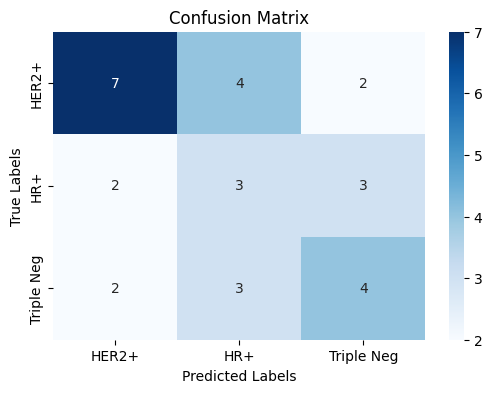

In [148]:
m_rf_1 = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = m_rf_1.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

best_params = nested_cv_rfc(X_train, y_train)

m_rf_optimized_1 = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = (best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized_1.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

In [130]:
print(best_params)

{'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_split': 2, 'n_estimators': 100}


## Trying different sets of features

### List 2 (features present in 2 or more feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.80      1.00      0.89         8
           2       1.00      0.78      0.88         9

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.92        30
weighted avg       0.95      0.93      0.93        30

Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Nested CV score (mean): 0.8857142857142858
Fitting 4 folds for each of 162 candidates, totalling 648 fits
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.78      0.88      0.82         8
           2       1.00      0.78  

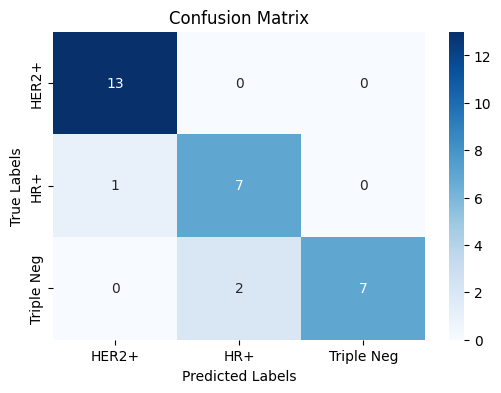

In [131]:
selected_features = [1902, 1956, 1973, 2026, 2058, 2183, 2184, 2207, 2211, 2213, 2547, 2593, 1672, 118, 192, 695, 772, 791, 854, 1061, 1091, 1559, 1643, 1656, 1678, 1900, 2017, 2021, 2024, 2210, 2218, 2750, 2776, 2791, 2817, 2825]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_2 = RandomForestClassifier(random_state = 42).fit(X_train, y_train)
y_pred = m_rf_2.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

best_params = nested_cv_rfc(X_train, y_train)

m_rf_optimized_2 = RandomForestClassifier(random_state = 42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = (best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized_2.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

In [132]:
print(best_params)

{'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_split': 2, 'n_estimators': 200}


### List 3 (features present in 3 or more feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.60      0.75      0.67         8
           2       0.71      0.56      0.62         9

    accuracy                           0.80        30
   macro avg       0.77      0.77      0.76        30
weighted avg       0.81      0.80      0.80        30

Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Nested CV score (mean): 0.9285714285714286
Fitting 4 folds for each of 162 candidates, totalling 648 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.64      0.88      0.74         8
           2       0.83      0.56  

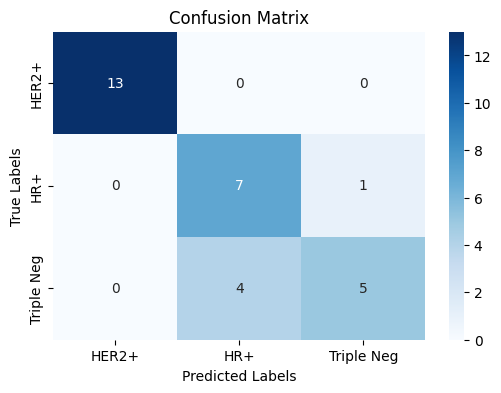

In [133]:
selected_features = [2026, 2184, 2213, 791, 1656, 1678, 1900, 2750]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_3 = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = m_rf_3.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

best_params = nested_cv_rfc(X_train, y_train)

m_rf_optimized_3 = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = (best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized_3.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

### List 4 (features present in 4 or more feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.50      0.88      0.64         8
           2       0.67      0.22      0.33         9

    accuracy                           0.73        30
   macro avg       0.72      0.70      0.66        30
weighted avg       0.77      0.73      0.70        30

Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Nested CV score (mean): 0.6571428571428571
Fitting 4 folds for each of 162 candidates, totalling 648 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.62      0.62      0.62         8
           2       0.67      0.67  

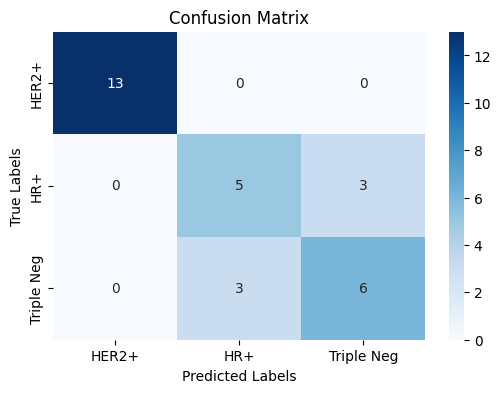

In [134]:
selected_features = [2026, 2184, 2213]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_4 = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = m_rf_4.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

best_params = nested_cv_rfc(X_train, y_train)

m_rf_optimized_4 = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = (best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized_4.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

### List 5 (features present in all feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.46      0.75      0.57         8
           2       0.50      0.22      0.31         9

    accuracy                           0.70        30
   macro avg       0.65      0.66      0.63        30
weighted avg       0.71      0.70      0.68        30

Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Fitting 4 folds for each of 162 candidates, totalling 648 fits
Nested CV score (mean): 0.6857142857142857
Fitting 4 folds for each of 162 candidates, totalling 648 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.46      0.75      0.57         8
           2       0.50      0.22  

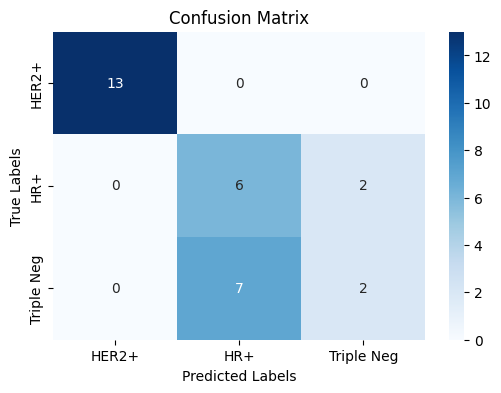

In [135]:
selected_features = [2184]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_5 = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = m_rf_5.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

best_params = nested_cv_rfc(X_train, y_train)

m_rf_optimized_5 = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = (best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized_5.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

In [136]:
print(y_pred_prob)

[[0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.45373375 0.54626625]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.45373375 0.54626625]
 [0.         0.53571382 0.46428618]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.53571382 0.46428618]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.         0.45373375 0.54626625]
 [0.         0.53571382 0.46428618]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [0.         0.53571382 0.46428618]
 [0.         0.53571382 0.46428618]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.  

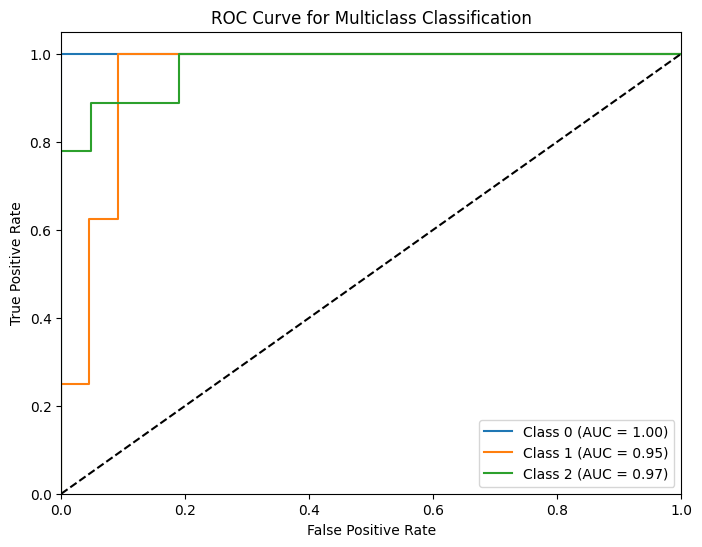

In [150]:
selected_features = [1902, 1956, 1973, 2026, 2058, 2183, 2184, 2207, 2211, 2213, 2547, 2593, 1672, 118, 192, 695, 772, 791, 854, 1061, 1091, 1559, 1643, 1656, 1678, 1900, 2017, 2021, 2024, 2210, 2218, 2750, 2776, 2791, 2817, 2825]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

roc_plot(X_train, X_test, y_train, y_test, m_rf_optimized_2)